In [1]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
currencies = ['CAD', 'SWISS', 'CNY', 'GBP', 'INR', 'JPY']

In [4]:
#PPP sredili da izgleda poput fajla GDP.xls, ljepse za obradu
PPP = pd.read_excel("./PPP.xlsx")

tmp = {'CAD':{}, 
       'SWISS': {}, 
       'CNY': {}, 
       'GBP': {},
       'INR':{},
       'JPY':{}}

for row in PPP.iterrows():
    location = row[1]['LOCATION']
    time = row[1]['TIME']
    value = row[1]['Value']
    tmp[location][time] = value

PPP = pd.DataFrame(tmp)

In [5]:
#GDP
GDP = pd.read_excel('./GDP.xls', index_col=0)

years = []
for year in np.arange(1981, 2017):
    years.append(str(year))           #ucitala godine

GDP = GDP[years].transpose()

In [6]:
#Ovdje pretvaram mjesecne kurseve u godisnje i na kraju to ucitam u jedan dataframe jer su svi bili u razlicitim txt fajlovima
tmp = {'CAD':{}, 
       'SWISS': {}, 
       'CNY': {}, 
       'GBP': {},
       'INR':{},
       'JPY':{}}

for currency in currencies:
    file = open(f'USD_{currency}.txt') 

    number = []
    for f in file:
        try:
            month, year, value = f.split()
            year, value = int(year)%100, float(value) #od godine otkinem zadnje dvije cifre, prilagodjavam da su svi txt fajlovi isti
        except:
            continue

        if year in np.remainder(np.arange(1981, 2017), 100):
            if year not in tmp[currency]:
                tmp[currency][year] = []

            tmp[currency][year].append(value)

    
for currency in currencies:
    for year in tmp[currency]:
        tmp[currency][year] = np.mean(tmp[currency][year])

exchange_rates = pd.DataFrame(tmp)

In [7]:
def predict(reg, old_y, weights, GDP, PPP):

      ret = [] #niz sa predvidjenim exchange rates od [1982 do 2016]

      weights = weights*100

      weights = np.append(weights, np.expand_dims(old_y, 1), 1)

      weights = np.append(weights, np.expand_dims(GDP, 1), 1)
      weights = np.append(weights, np.expand_dims(PPP, 1), 1)
      
      for i in np.arange(2000, 2015):
          reg.fit(weights[0:(i - 1981)], old_y[1:(i - 1981)+1]) #treniramo na train podacima 
          prediction = reg.predict([weights[i - 1981]])         #pokusavamo da predvidimo vrijednost za sledecu godinu, testiramo na test podacima
          ret.append(prediction)                                # u ret dodajemo predvidjanja od 2000-2015

      return ret, reg


CAD    LinearRegression          5  0.08
CAD    LinearRegression          10 0.07
CAD    LinearRegression          20 0.66
CAD    LinearRegression          25 1.05
CAD    LinearRegression          50 0.08
CAD    Ridge                     5  0.08
CAD    Ridge                     10 0.08
CAD    Ridge                     20 0.07
CAD    Ridge                     25 0.09
CAD    Ridge                     50 0.07
CAD    SVR                       5  0.05
CAD    SVR                       10 0.05
CAD    SVR                       20 0.05
CAD    SVR                       25 0.05
CAD    SVR                       50 0.05
CAD    RandomForestRegressor     5  0.06
CAD    RandomForestRegressor     10 0.06
CAD    RandomForestRegressor     20 0.06
CAD    RandomForestRegressor     25 0.05
CAD    RandomForestRegressor     50 0.06
SWISS  LinearRegression          5  0.19
SWISS  LinearRegression          10 0.28
SWISS  LinearRegression          20 1.21
SWISS  LinearRegression          25 4.01
SWISS  LinearReg

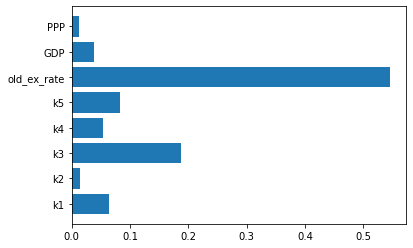

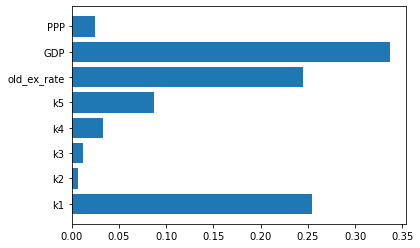

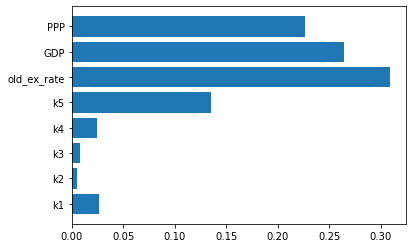

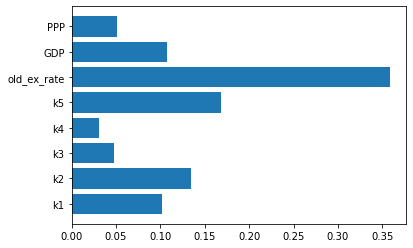

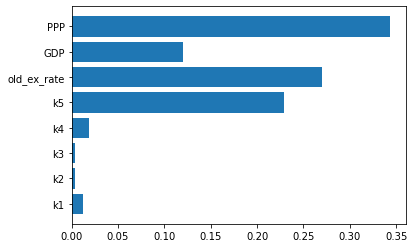

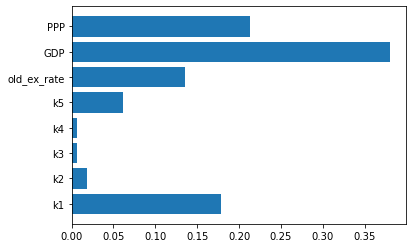

<Figure size 432x288 with 0 Axes>

In [8]:
for currency in currencies:#valuta koju obradjujemo
    _GDP = GDP[currency].to_numpy() #uzimamo GDP samo za tu valutu
    _PPP = PPP[currency].to_numpy()
    _exchange_rates = exchange_rates[currency]

    model_names = ['LinearRegression', 'Ridge', 'SVR', 'RandomForestRegressor']
    
    for network in range(0, 4):#model koji koristimo za regresiju
        reg = None
        if network == 0:
            reg = LinearRegression()
        if network == 1:
            reg = Ridge(alpha=0.01, normalize=True)
        if network == 2:
            reg = SVR(gamma='auto', kernel='rbf')
        if network == 3:
            reg = RandomForestRegressor(n_estimators = 100)

        for k in [5, 10, 20, 25, 50]: #broj klastera koje smo koristili prilikom klasifikacije dokumenata
            weights = np.load(f'Weights/{k}.npy')
            prediction, reg = predict(reg, _exchange_rates[:-1], weights, _GDP[:-1], _PPP[:-1]) 
            #svi podaci se odnose na godine [1981,2015], predictions se odnosi na [1982, 2016]
            if k==5 and network==3:
                #reg.feature_importances_
                plt.barh(['k1', 'k2', 'k3', 'k4', 'k5', 'old_ex_rate', 'GDP', 'PPP'], reg.feature_importances_)
                plt.figure()

            error_rate = np.mean((prediction -_exchange_rates[2000-2016:].to_numpy())**2)
            print('%-6s %-25s %-2d %.2f'%(currency, model_names[network], k, error_rate))

#stampa za svaku valutu i za svaki regresor i za svako k kolika je greska
#greska koju racunam je mean squared error
    